In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [86]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    encoded = model.encoder(data_point)
    reconstruction = model.decoder(encoded)

    Z_features = [Z_calculations.getZVector(data_point, reconstruction, encoded)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [87]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data_point), data_point), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [88]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [89]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [90]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [91]:
#min_val = tf.reduce_min(np_train_data)
#max_val = tf.reduce_max(np_train_data)

#np_train_data = (np_train_data - min_val) / (max_val - min_val)
#np_test_data = (np_test_data - min_val) / (max_val - min_val)

np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [92]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [93]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [94]:
autoencoder.compile(optimizer='adam', loss='mae')

In [95]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector_2/sequential_4/dense_14/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_2/sequential_5/dense_17/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector_2/sequential_4/dense_14/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_2/sequential_5/dense_17/Sigmoid:0", shape=(None, 46), dtype=float32)
2079/2105 [============================>.] - ETA: 0s - loss: 0.0437Tensor("anomaly_detector_2/sequential_4/dense_14/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_2/sequential_5/dense_17/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 5s 2ms/step - loss: 0.0434 - val_loss: 0.0653
Epoch 2/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.0184 - val_loss: 0.0640
Epoch 3/100
2105/2105 [==============================] - 3s 2ms/step - loss: 0.0165 - val_loss: 0.0621
Epoch 4/100
2105/2105 [==============================] - 4s 2ms/step - l

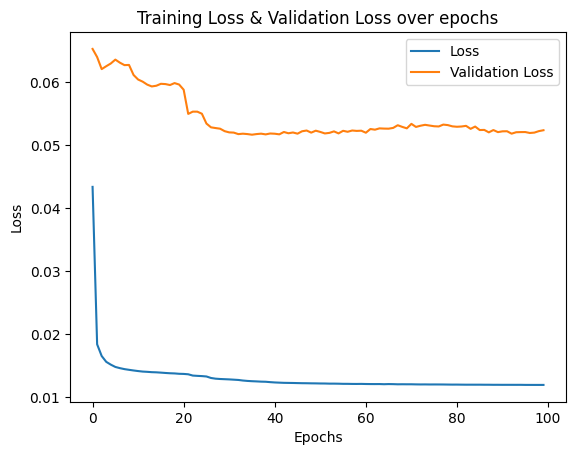

In [96]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [97]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector_2/sequential_4/dense_14/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_2/sequential_5/dense_17/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 2s 978us/step
Threshold:  0.04057756


In [98]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(data, reconstructions) # 0 = anomaly (same as data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [99]:
%%timeit

predict(autoencoder, np_test_data, threshold)

tf.Tensor(
[[2.1546493  0.33109957 1.2372931  ... 2.11412    0.8085469  1.5878651 ]
 [2.2737937  0.14947124 1.3899742  ... 2.1720798  0.590058   1.5073308 ]
 [1.5533661  0.9966737  3.6606364  ... 2.1277351  1.9422388  1.7253466 ]
 ...
 [1.1986796  3.4589324  1.9196913  ... 3.3635082  2.096858   2.4088032 ]
 [1.548331   2.7785265  3.4247928  ... 3.292157   1.190875   1.8909587 ]
 [5.94829    0.5153585  2.4230528  ... 4.4864726  0.         3.5448058 ]], shape=(22544, 8), dtype=float32)
tf.Tensor(
[[5.99759531e-08 7.94714481e-08 6.67048994e-08 ... 6.96482090e-08
  2.59945637e-07 5.87968501e-08]
 [2.80239760e-08 3.09424841e-08 2.71204588e-08 ... 2.95664346e-08
  1.17581180e-07 2.58354191e-08]
 [1.92220390e-16 1.66652123e-15 5.17318914e-16 ... 2.59502721e-17
  1.32487568e-15 1.46404351e-16]
 ...
 [1.45091688e-16 1.31353783e-15 5.49440891e-16 ... 3.95523855e-17
  1.14338335e-14 2.43823145e-16]
 [3.99295633e-17 2.56780103e-16 1.43456584e-16 ... 1.40347867e-17
  1.11604881e-15 1.54007451e-16]


In [100]:
%%capture

test_predictions = predict(autoencoder, np_test_data, threshold)

### Stats for whole dataset

In [101]:
print_stats(test_predictions, test_labels)

Accuracy = 0.7747959545777147
Precision = 0.6595290553566511
Recall = 0.9864071671300587


In [102]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels, test_predictions)

array([[7888, 4945],
       [ 132, 9579]], dtype=int64)

In [103]:
test_labels_swap = []
for i in range(len(test_labels)):
    if test_labels[i]:
        test_labels_swap.append(False)
    else:
        test_labels_swap.append(True)

test_labels = test_labels_swap
np_test_labels = test_labels

### Stats for all predicted anomalous data

In [104]:
from pandas import DataFrame
from turtleIsolationForests.printResults import print_results

test_predictions_np = test_predictions.numpy()

autoec_predictions = DataFrame()

autoec_predictions['predicted_as_anomaly'] = test_predictions_np
autoec_predictions['is_normal'] = test_labels

print_results(autoec_predictions)

true anomalies: 9579
false anomalies: 4945
false normals: 132
true normals: 7888
precision: 0.6595290553566511
recall: 0.9864071671300587
f1-score: 0.7905095935630286


In [105]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze())

    return pd.DataFrame(data_with_Z_rf)

In [106]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

In [111]:
np_test_labels = np.array(np_test_labels)

In [112]:
predicted_anomalous = np_test_data[test_predictions.numpy()]

In [113]:
predicted_anomalous_labels = np_test_labels[test_predictions.numpy()]

In [114]:
anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)

In [115]:
contamination = sum(train_labels == 0) / len(train_labels)

In [116]:
# need test_predictions replaced at indices that autoencoder predicted anomalies

In [117]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results

eif = ExtendedIsolationForest(contamination = contamination, random_state = None)
eif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [118]:
%%timeit

eif.predict(anomalous_test_data_with_Z_df)

35.7 s ± 567 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [119]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_normal'] = predicted_anomalous_labels

print_results(eif_predictions)

true anomalies: 4757
false anomalies: 2494
false normals: 4822
true normals: 2451
precision: 0.6560474417321749
recall: 0.49660716149911266
f1-score: 0.5653000594177064


In [120]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination = contamination, num_hyperplanes_per_split=5, random_state = None)
scif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [121]:
%%timeit

scif.predict(anomalous_test_data_with_Z_df)

1min 39s ± 704 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_normal'] = predicted_anomalous_labels

print_results(scif_predictions)

true anomalies: 4721
false anomalies: 2480
false normals: 4858
true normals: 2465
precision: 0.6556033884182753
recall: 0.4928489403904374
f1-score: 0.5626936829558998


In [123]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination = contamination, random_state = None)
isoforest.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [124]:
%%timeit

isoforest.predict(anomalous_test_data_with_Z_df)

27 s ± 590 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
snisoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_normal'] = predicted_anomalous_labels

print_results(isoforest_predictions)

true anomalies: 4730
false anomalies: 2503
false normals: 4849
true normals: 2442
precision: 0.6539471865062906
recall: 0.49378849566760624
f1-score: 0.5626933142993099


In [126]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination = contamination, random_state = None)
fbif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [127]:
%%timeit

fbif.predict(anomalous_test_data_with_Z_df)

2min 42s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_normal'] = predicted_anomalous_labels

print_results(fbif_predictions)

true anomalies: 4758
false anomalies: 2499
false normals: 4821
true normals: 2446
precision: 0.6556428276147168
recall: 0.49671155652990917
f1-score: 0.5652173913043478
